In [497]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import win32com.client
import re

# product labeling index from classification.py
from classification import product_classification
from location import location_classification

## Personal variables

In [ ]:
subfolder_name = "testing_project2" # folder name of Outlook
nature_selected = "Stock 1" # The item selected for the visualization
location_selected = "TFDL" # The location selected for the item visualization

## Connect to outlook

In [499]:
# Connect to Outlook
outlook = win32com.client.Dispatch("Outlook.Application").GetNamespace("MAPI")

# Get the default Inbox folder (index 6 is usually the inbox)
inbox = outlook.GetDefaultFolder(6)

# Print the inbox name and loop through its subfolders
print(f"Inbox: {inbox.Name}")
for i, folder in enumerate(inbox.Folders):
    print(f"Subfolder Index {i}: {folder.Name}")

Inbox: Inbox
Subfolder Index 0: testing_project2
Subfolder Index 1: Stars


### Dataframe Skeleton

In [500]:
# Contruct the skeleton
tempdatastruc = {
    "Order Number" : [],
    "Date": [],
    "Location": [],
    "Product Description" : [],
    "QTY": []
}

## Extract info from email inbox subfolder

In [501]:
# Access the subfolder at index 0 or (in this case, "testing_project2")
subfolder = inbox.Folders[subfolder_name] 
# Alternative way by using subfolder at index 0: 
# subfolder = inbox.Folders[0]

print(f"Accessing subfolder: {subfolder.Name}")

# Get the messages from the subfolder
messages = subfolder.Items
for message in messages:
    # Import the Email Body
    email_body = message.Body

    # Split the email body into lines
    lines = email_body.strip().split("\n")
    
    # Initialize variables to store items and summary
    items = []
    summary = {}

    processing_items = False
    
    # Loop through each line in the email
    for line in lines:
        line = line.strip()  # Remove leading/trailing whitespaces

        # If we encounter the header line, start processing items from the next line
        if "SKU" in line and "Product" in line and "MANUFACTURER NO" in line:
            processing_items = True
            continue  # Skip the header line itself
        
        # If we reach the Subtotal, stop processing items
        if "Subtotal" in line:
            processing_items = False
        
        # Processing item lines
        if processing_items:
            entry_list = line.split("\t")
            data_dict = {
            'SKU': entry_list[0],
            'Product Description': entry_list[1],
            'Manufacturer number': entry_list[2],
            'CPN': entry_list[3],
            'QTY': entry_list[4],
            'UOM': entry_list[5],
            'Price': entry_list[6],
            'Total': entry_list[7]  
            }
            items.append(data_dict)

        else:
            # For summary lines, extract key-value pairs
            summary_data = re.split(r'\s{2,}', line)
            if len(summary_data) == 2:
                summary[summary_data[0].strip().replace(":", "")] = summary_data[1].strip()
    
    
    # For each product, enter into the df skeleton (Please visit v0.2 for more details)
    for item in items:
        tempdatastruc["Order Number"].append(summary["Order Number"])
        tempdatastruc["Date"].append(summary["Requested Delivery Date"])
        tempdatastruc["Location"].append(summary["Location"])
        tempdatastruc["Product Description"].append(item["Product Description"].strip())
        tempdatastruc["QTY"].append(item["QTY"])

Accessing subfolder: testing_project2


# Construct DataFrame

In [502]:
df = pd.DataFrame(tempdatastruc)

## Extract Location Code

In [503]:
# Extract Location Code from the Location
df['Location Code'] = df['Location'].str.extract(r'\(([^)]+)\)')

# Move the Location Code next to Location column
cols = list(df.columns)
loc_index = cols.index('Location')
cols.insert(loc_index + 1, cols.pop(cols.index('Location Code')))
df = df[cols]

## Labeling the Product and Location

In [504]:
# Product nature
df.loc[:, 'Product Nature'] = df['Product Description'].map(product_classification)
df.loc[:, 'Product Nature'] = df['Product Nature'].fillna('None')

# Move the Product Nature next to Product Description
cols = list(df.columns)
loc_index = cols.index('Product Description')
cols.insert(loc_index + 1, cols.pop(cols.index('Product Nature')))
df = df[cols]

In [505]:
# Product nature
df.loc[:, 'Location Label'] = df['Location Code'].map(location_classification)
df.loc[:, 'Location Label'] = df['Location Label'].fillna('None')

# Move the Location Label next to Location Code
cols = list(df.columns)
loc_index = cols.index('Location Code')
cols.insert(loc_index + 1, cols.pop(cols.index('Location Label')))
df = df[cols]

### Set QTY to numeric

In [506]:
df['QTY'] = pd.to_numeric(df['QTY'])

### Extra: Stat of None Label vs other (Testing the % of labeling)

In [508]:
none_count = (df['Product Nature'] == 'None').sum()
label_completion_rate_Nature = (1 - none_count / len(df['Product Nature'])) * 100
none_count = (df['Location Label'] == 'None').sum()
label_completion_rate_Location = (1 - none_count / len(df['Product Nature'])) * 100
print(f"Nature Labeling completion rate: {label_completion_rate_Nature} %")
print(f"Location Labeling completion rate: {label_completion_rate_Location} %")

Nature Labeling completion rate: 21.153846153846157 %
Location Labeling completion rate: 14.423076923076927 %


# Grouping the data for plotting

## Separate the data in Year, Month and Date

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day


## Filter and grouping the things (without location limit)

In [ ]:
filtered_df = df[df["Product Nature"] == nature_selected]
# df2 = filtered_df[["Location Label", "Year", "Month","Day", "Product Nature", "QTY", "Date"]]
df2 = filtered_df[["Year", "Month","Day", "Product Nature", "QTY", "Date"]]
df2

In [ ]:
df2 = filtered_df[["Year", "Month", "QTY", "Date"]]
df2

In [512]:
# Group the data by year, Make sure the table looks like this at the end (Year, Month, QTY)
grouped_data = df2.groupby(['Year', 'Month'], as_index=False).agg({'QTY': 'sum'})
grouped_data

,Year,Month,QTY
0,2023,12,40
1,2024,1,18
2,2024,2,40
3,2024,4,60
4,2024,9,30
5,2024,10,66


## Trying to make a graph

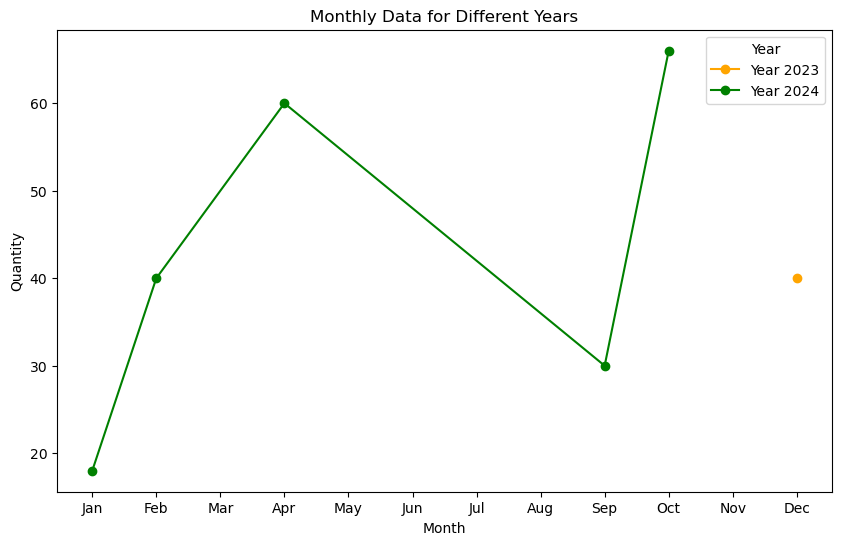

In [513]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define a color map for years
colors = {2022: 'blue', 2023: 'orange', 2024: 'green'}

# Loop through each year in the grouped data and plot a line
for year, group in grouped_data.groupby("Year"):
    plt.plot(group['Month'], group['QTY'], marker="o", color=colors[year], label=f'Year {year}')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.title('Monthly Data for Different Years')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
plt.legend(title='Year')


# Table
grouped_data
# Show the plot
plt.show()


In [514]:
print(f"Nature Labeling completion rate: {label_completion_rate_Nature} %")
print(f"Location Labeling completion rate: {label_completion_rate_Location} %")

Nature Labeling completion rate: 21.153846153846157 %
Location Labeling completion rate: 14.423076923076927 %
